In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.api.types import CategoricalDtype

In [2]:
df = pd.read_csv('../data/raw/train.csv')

# Création de la colonne datetime
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')

# Agrégation mensuelle
monthly_avg = df.groupby('Date')['SalePrice'].mean().reset_index()
monthly_avg.columns = ['Date', 'AverageSalePrice']

# Mise en index datetime
monthly_avg.set_index('Date', inplace=True)
monthly_avg.index.name = 'Date'

#setting correct dtype
#'Utilities' potentiel ordinal?
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].astype('category')
df['MSSubClass'] = df['MSSubClass'].astype('category')
df['Alley'] = df['Alley'].astype(CategoricalDtype(categories=['Grvl', 'Pave', 'NA'], ordered=False))
df['LotShape'] = df['LotShape'].astype(CategoricalDtype(categories=['IR3', 'IR2', 'IR1', 'Reg'], ordered= True))
df['LandSlope'] = df['LandSlope'].astype(CategoricalDtype(categories=['Sev', 'Mod', 'Gtl'], ordered= True))
df['OverallQual'] = df['OverallQual'].astype(CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered= True))
df['OverallCond'] = df['OverallCond'].astype(CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered= True))
df['ExterQual'] = df['ExterQual'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered= True))
df['ExterCond'] = df['ExterCond'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered= True))
df['BsmtQual'] = df['BsmtQual'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered= True))
df['BsmtCond'] = df['BsmtCond'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered= True))
df['BsmtExposure'] = df['BsmtExposure'].astype(CategoricalDtype(categories=['Gd', 'Av', 'Mn', 'No', 'NA'], ordered= True))
df['BsmtFinType1'] = df['BsmtFinType1'].astype(CategoricalDtype(categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered= True))
df['BsmtFinType2'] = df['BsmtFinType2'].astype(CategoricalDtype(categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered= True))
df['HeatingQC'] = df['HeatingQC'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered= True))
df['KitchenQual'] = df['KitchenQual'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered= True))
df['FireplaceQu'] = df['FireplaceQu'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered= True))
df['GarageQual'] = df['GarageQual'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered= True))
df['GarageCond'] = df['GarageCond'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered= True))
df['PoolQC'] = df['PoolQC'].astype(CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'NA'], ordered= True))



df.info()
# df['Alley'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1460 non-null   int64         
 1   MSSubClass     1460 non-null   category      
 2   MSZoning       1460 non-null   category      
 3   LotFrontage    1201 non-null   float64       
 4   LotArea        1460 non-null   int64         
 5   Street         1460 non-null   category      
 6   Alley          91 non-null     category      
 7   LotShape       1460 non-null   category      
 8   LandContour    1460 non-null   category      
 9   Utilities      1460 non-null   category      
 10  LotConfig      1460 non-null   category      
 11  LandSlope      1460 non-null   category      
 12  Neighborhood   1460 non-null   category      
 13  Condition1     1460 non-null   category      
 14  Condition2     1460 non-null   category      
 15  BldgType       1460 n

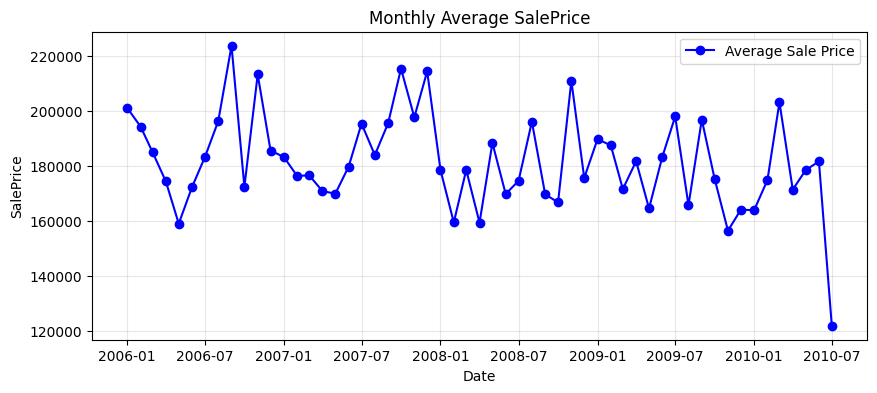

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg, label='Average Sale Price', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('Monthly Average SalePrice')
plt.xlabel('Date')
plt.ylabel('SalePrice')
plt.legend()
plt.show()


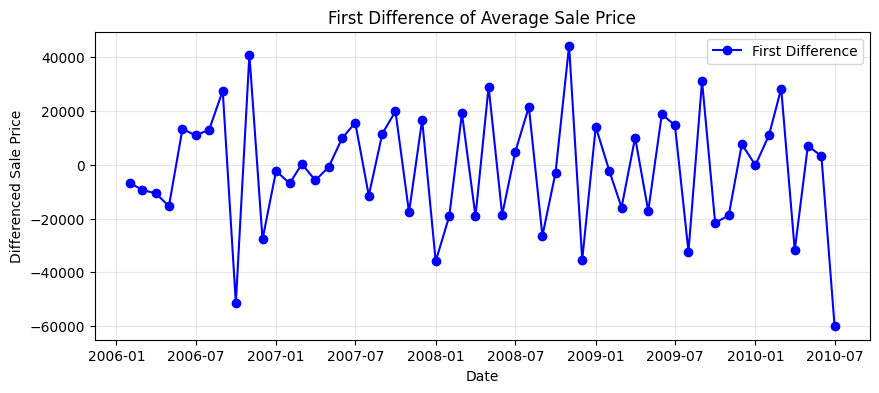

In [4]:
monthly_diff = monthly_avg['AverageSalePrice'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(monthly_diff, label='First Difference', marker='o', linestyle='-', color='blue')
plt.grid(True, alpha=0.3)
plt.title('First Difference of Average Sale Price')
plt.xlabel('Date')
plt.ylabel('Differenced Sale Price')
plt.legend()
plt.show()

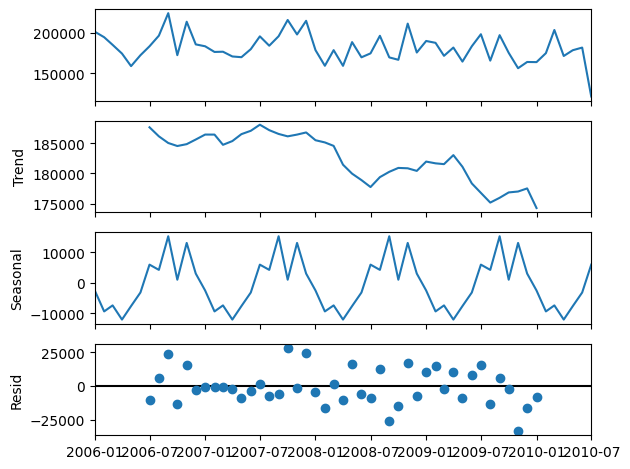

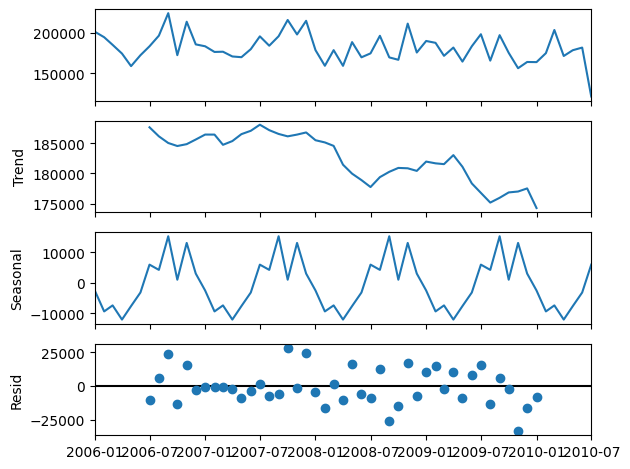

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_add = seasonal_decompose(monthly_avg, model='additive')
decomp_add.plot()

In [6]:
X_orig = np.arange(len(monthly_avg)).reshape(-1, 1)
X_orig_const = sm.add_constant(X_orig)
y_orig = monthly_avg['AverageSalePrice'].values
model_orig = sm.OLS(y_orig, X_orig_const).fit()
original_p_values = model_orig.pvalues[1]
print(f"Original series trend p-value: {original_p_values:.4f}")

Original series trend p-value: 0.0254


In [7]:
log_avg = np.log(monthly_avg['AverageSalePrice'])
log_diff = log_avg.diff().dropna()

X_log_diff = np.arange(len(log_diff)).reshape(-1, 1)
X_log_diff_const = sm.add_constant(X_log_diff)
y_log_diff = log_diff.values
model_log_diff = sm.OLS(y_log_diff, X_log_diff_const).fit()
log_diff_p_value = model_log_diff.pvalues[1]
print(f"Log-differenced series trend p-value: {log_diff_p_value:.4f}")

Log-differenced series trend p-value: 0.5835


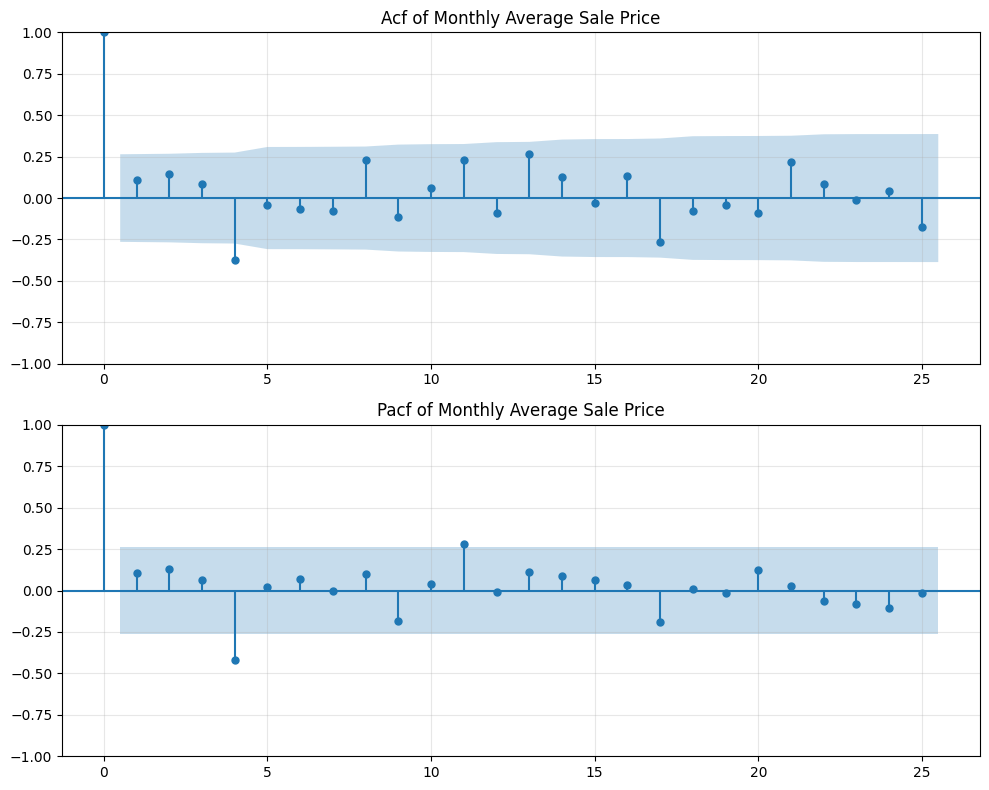

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(monthly_avg, lags=25, ax=axes[0])
axes[0].set_title('Acf of Monthly Average Sale Price')
axes[0].grid(True, alpha=0.3)

plot_pacf(monthly_avg, lags=25, ax=axes[1])
axes[1].set_title('Pacf of Monthly Average Sale Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print(monthly_avg)
print(np.log(monthly_avg))

            AverageSalePrice
Date                        
2006-01-01     201090.000000
2006-02-01     194322.222222
2006-03-01     184982.200000
2006-04-01     174312.814815
2006-05-01     158928.289474
2006-06-01     172283.333333
2006-07-01     183211.059701
2006-08-01     196239.956522
2006-09-01     223768.866667
2006-10-01     172356.708333
2006-11-01     213285.000000
2006-12-01     185545.000000
2007-01-01     183234.615385
2007-02-01     176301.750000
2007-03-01     176567.782609
2007-04-01     170772.608696
2007-05-01     169873.511628
2007-06-01     179725.813559
2007-07-01     195396.843137
2007-08-01     183941.075000
2007-09-01     195533.818182
2007-10-01     215428.812500
2007-11-01     197709.333333
2007-12-01     214414.500000
2008-01-01     178504.692308
2008-02-01     159370.000000
2008-03-01     178505.277778
2008-04-01     159293.346154
2008-05-01     188334.473684
2008-06-01     169730.941176
2008-07-01     174562.653061
2008-08-01     196076.965517
2008-09-01    

In [9]:
# from pmdarima import auto_arima

# model = auto_arima(
#     monthly_avg,
#     seasonal=True,
#     m=12,  # Monthly data
#     trace=True,
#     error_action='ignore',
#     suppress_warnings=True,
#     stepwise=True
# )

In [14]:
df_1 = pd.read_csv('../data/raw/train.csv')

# df_ord_num = pd.read_csv('../data/clean_reclean/ordinal_numerized_cleaned.csv', usecols=['KitchenQual_code'])
# df_1['KitchenQual_Code'] = df_ord_num['KitchenQual_code']
df_ord_num = pd.read_csv('../data/clean_reclean/ordinal_numerized_cleaned.csv', usecols=['Id', 'KitchenQual_code'])
df_1 = df_1.merge(df_ord_num, on='Id', how='left')

df_1['Date'] = pd.to_datetime(df_1['YrSold'].astype(str) + '-' + df_1['MoSold'].astype(str) + '-01')
df_1.set_index('Date', inplace=True)
# exog_data = df_1.resample('ME').agg({'KitchenQuak_code': 'mean'}).dropna()
# Aggregate to monthly average
exog_data = df_1.resample('ME').agg({
    'SalePrice': 'mean',
    'KitchenQual_code': 'mean'
}).dropna()

# Fix datetime index frequency
exog_data.index = pd.date_range(start=exog_data.index[0], periods=len(exog_data), freq='ME')

# Log-transform SalePrice
exog_data = exog_data[['KitchenQual_code']]
print(len(exog_data))
print(len(monthly_avg))






55
55


In [30]:
# Trying to make exog work, it does not

from statsmodels.tsa.statespace.sarimax import SARIMAX

# #Split dataset,
n = len(monthly_avg)
# split = int(n * 0.8)  # 80% for training, 20% for testing
# split2 = int(n * 0.2) 
# train = pd.concat([monthly_avg.iloc[:split2], monthly_avg.iloc[split:]])
# test = monthly_avg.iloc[split2:split]

split = int(n * 0.8)  # 80% for training, 20% for testing
train = monthly_avg.iloc[:split]
test = monthly_avg.iloc[split:]
train_exog = exog_data.iloc[:split]
test_exog = exog_data.iloc[split:]

#Specify combinations,
# Specify combinations
non_seasonal_orders = [
    (1,1,1), (2,1,1), (1,1,0)
]

seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (0,0,0,12), (2,0,1,12)
]

# Dictionary to hold results,
results = {}

# Loop over combinations,
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        history = train.copy()
        exog_hist = train_exog.copy()

        for t in range(len(test)):
            model = SARIMAX(endog= history,
                            exog= exog_hist,
                            order=ns_order,
                            seasonal_order=s_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

            forecast = model.forecast(steps=1).iloc[0]
            actual = test['AverageSalePrice'].iloc[t]

            preds.append(forecast)
            actuals.append(actual)

            # Update history with actual
            history = pd.concat([history, test.iloc[[t]]])

        errors = np.array(actuals) - np.array(preds)
        var_error = np.std(errors) / np.mean(actuals)

        results[label] = {
            'Forecasts': preds,
            'Actuals': actuals,
            'Errors': errors,
            'Variance of Forecast Error': var_error
        }

# Create summary DataFrame and get best two models,
summary_df = pd.DataFrame([
    {'Model': name, 'Forecast Error Variance': res['Variance of Forecast Error']}
    for name, res in results.items()
]).sort_values('Forecast Error Variance').reset_index(drop=True)



print(summary_df)
# Plot only top 2 models,
for name in summary_df['Model'][:2]:
    res = results[name]
    # Ensure both x and y are numpy arrays of the same length
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    print(forecasts)
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    


ValueError: SARIMAX models require univariate `endog`. Got shape (44, 2).

c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\U

                                   Model  Relative Forecast Error Variance  \
0   ARIMA(1, 1, 0) x SARIMA(1, 0, 1, 12)                      1.953658e-02   
1   ARIMA(1, 1, 0) x SARIMA(1, 0, 0, 12)                      2.027828e-02   
2   ARIMA(1, 1, 1) x SARIMA(1, 0, 0, 12)                      2.103865e-02   
3   ARIMA(2, 1, 1) x SARIMA(0, 0, 0, 12)                      2.117340e-02   
4   ARIMA(2, 1, 1) x SARIMA(1, 0, 0, 12)                      2.123752e-02   
5   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)                      2.398270e-02   
6   ARIMA(1, 1, 0) x SARIMA(0, 0, 0, 12)                      2.707231e-02   
7   ARIMA(2, 1, 1) x SARIMA(1, 1, 1, 12)                      3.270416e-02   
8   ARIMA(2, 1, 1) x SARIMA(1, 1, 0, 12)                      3.446666e-02   
9   ARIMA(1, 1, 0) x SARIMA(1, 1, 1, 12)                      3.775600e-02   
10  ARIMA(1, 1, 0) x SARIMA(1, 1, 0, 12)                      4.137395e-02   
11  ARIMA(1, 1, 1) x SARIMA(1, 1, 1, 12)                      4.

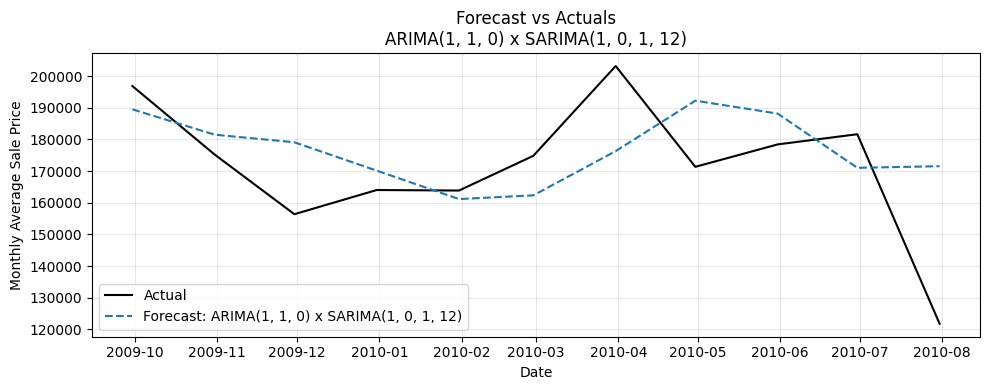

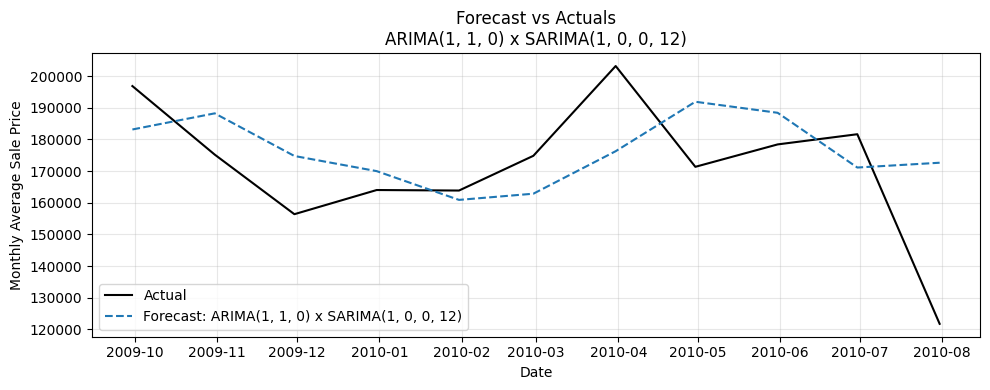

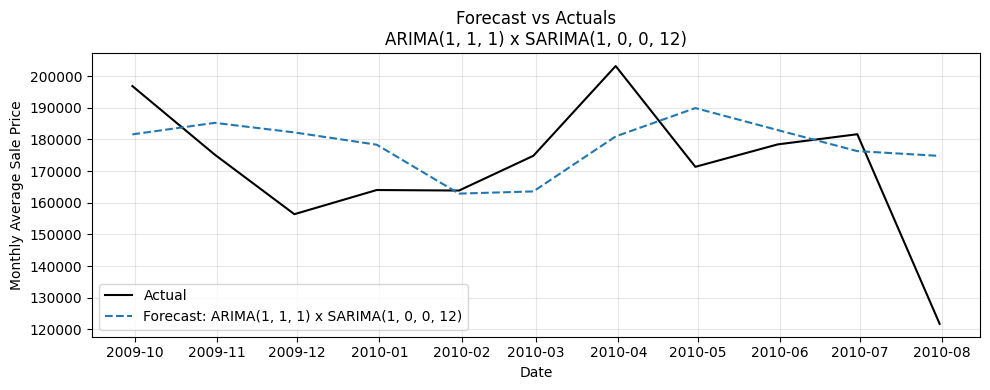

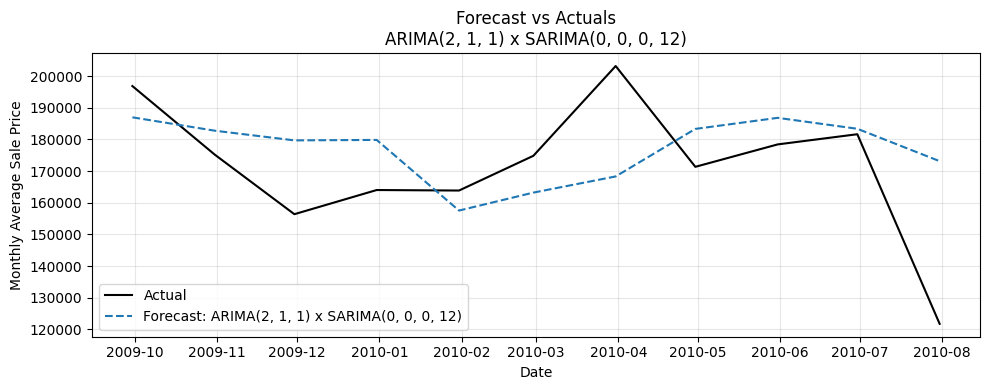

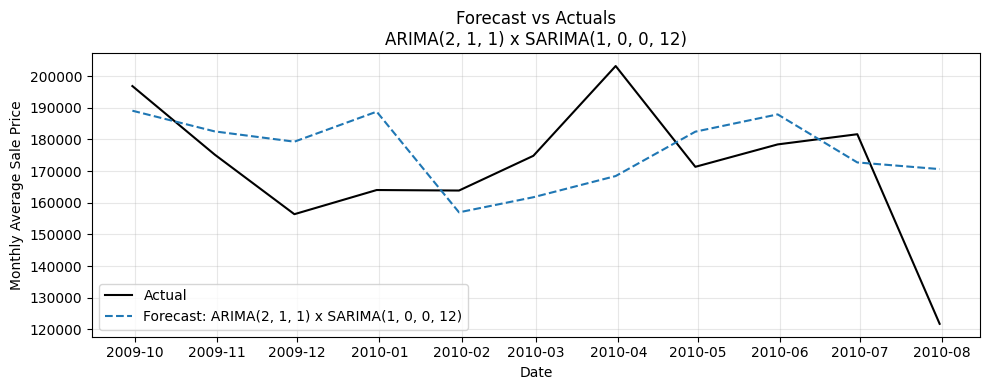

In [35]:
# Monthly average fitted with SARIMAX 

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure datetime index
monthly_avg.index = pd.to_datetime(monthly_avg.index)

# Rename for consistency (if needed)
monthly_avg.rename(columns={'SalePrice': 'AverageSalePrice'}, inplace=True)

# Split dataset
n = len(monthly_avg)
split = int(n * 0.8)  # 80% for training, 20% for testing

train = monthly_avg.iloc[:split]
test = monthly_avg.iloc[split:]

# SARIMA order combinations
non_seasonal_orders = [(1,1,1), (2,1,1), (1,1,0)]
seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (0,0,0,12), (1,0,0,12), (1,0,1,12)
]

results = {}

# Loop over models
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(
                    history['AverageSalePrice'],
                    order=ns_order,
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                forecast = model.forecast(steps=1).iloc[0]
                actual = test['AverageSalePrice'].iloc[t]

                preds.append(forecast)
                actuals.append(actual)
                aics.append(model.aic)

                # Update history with actual
                new_row = test.iloc[[t]]
                history = pd.concat([history, new_row])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            actuals_arr = np.array(actuals)
            preds_arr = np.array(preds)
            relative_errors = (preds_arr - actuals_arr) / actuals_arr
            var_error = np.nanvar(relative_errors)
            avg_aic = np.nanmean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': relative_errors,
                'Relative Forecast Error Variance': var_error,
                'AIC': avg_aic
            }

# Summary DataFrame
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Relative Forecast Error Variance': res['Relative Forecast Error Variance'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Relative Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Relative Forecast Error Variance', 'AIC']])

# Plot top 5 models
for name in summary_df['Model'][:5]:
    res = results[name]
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\U

                                   Model  Relative Forecast Error Variance  \
0   ARIMA(2, 1, 1) x SARIMA(1, 0, 1, 12)                          0.015706   
1   ARIMA(1, 1, 0) x SARIMA(1, 0, 1, 12)                          0.016365   
2   ARIMA(1, 1, 1) x SARIMA(1, 0, 1, 12)                          0.017028   
3   ARIMA(2, 1, 1) x SARIMA(1, 0, 0, 12)                          0.020216   
4   ARIMA(1, 1, 0) x SARIMA(1, 0, 0, 12)                          0.020541   
5   ARIMA(2, 1, 1) x SARIMA(0, 0, 0, 12)                          0.021155   
6   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)                          0.023385   
7   ARIMA(1, 1, 1) x SARIMA(1, 0, 0, 12)                          0.023761   
8   ARIMA(1, 1, 0) x SARIMA(0, 0, 0, 12)                          0.027117   
9   ARIMA(2, 1, 1) x SARIMA(1, 1, 0, 12)                          0.028037   
10  ARIMA(2, 1, 1) x SARIMA(1, 1, 1, 12)                          0.034773   
11  ARIMA(1, 1, 1) x SARIMA(1, 1, 0, 12)                        

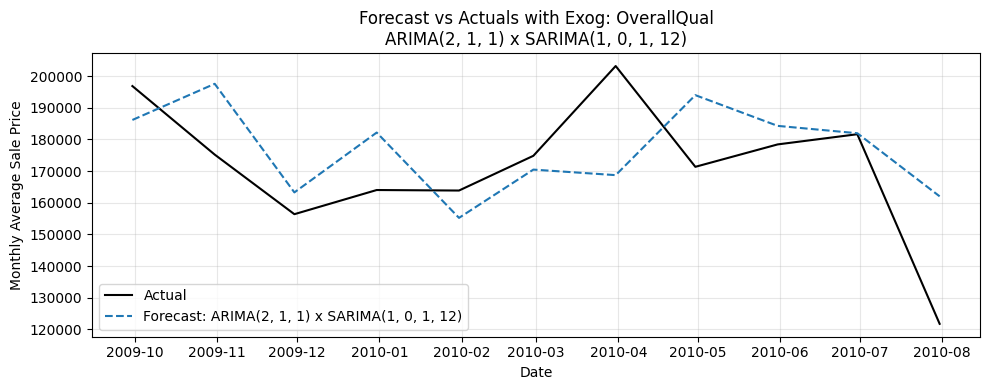

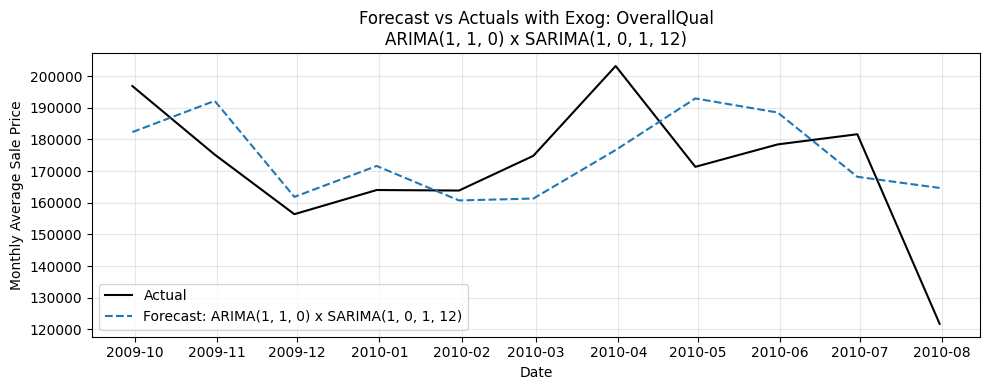

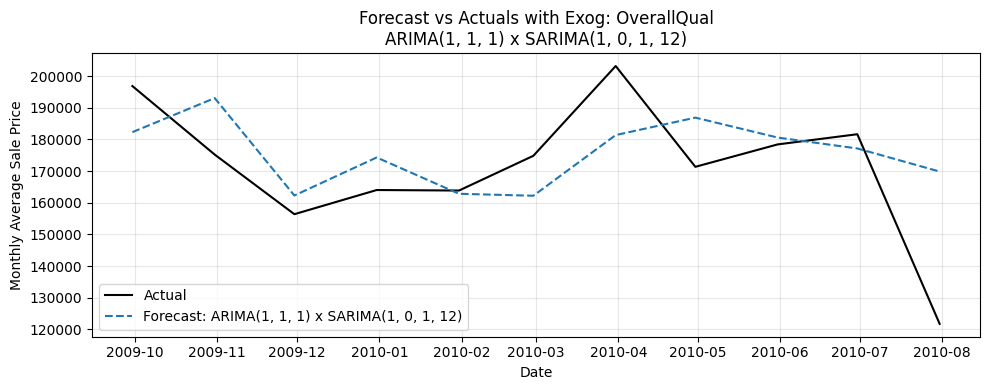

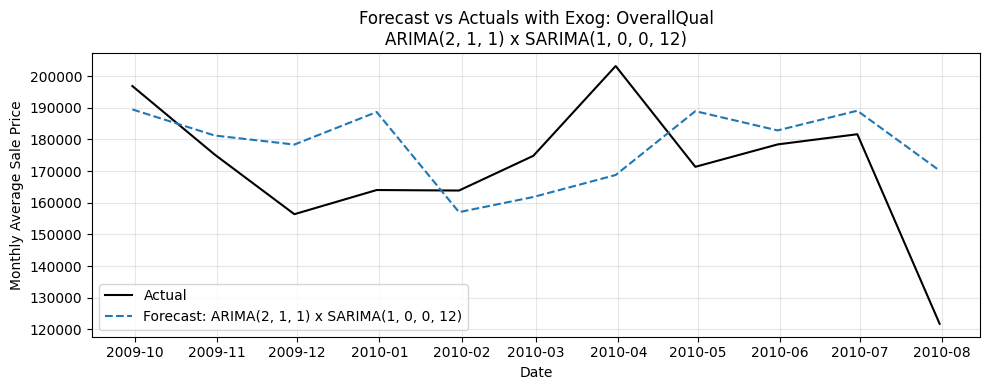

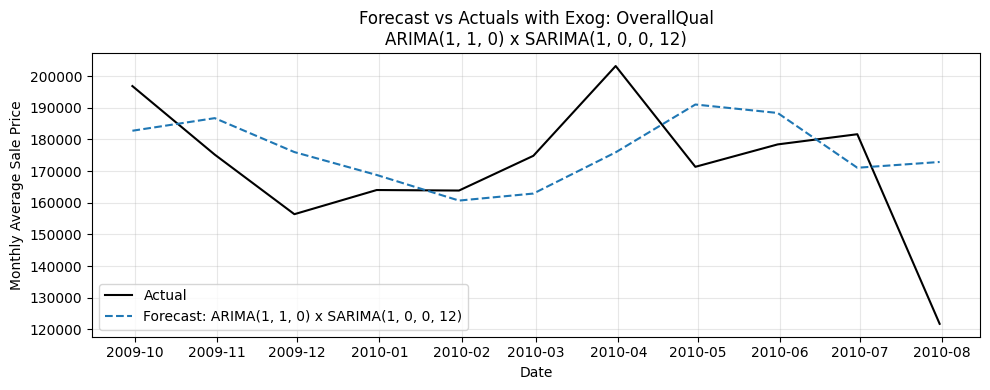

In [34]:
# Log of monthly average fitted with SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure datetime index
monthly_avg.index = pd.to_datetime(monthly_avg.index)

monthly_avg.rename(columns={'SalePrice': 'AverageSalePrice'}, inplace=True)

# Log-transform the target
log_monthly_avg = np.log(monthly_avg['AverageSalePrice']).to_frame(name='LogAverageSalePrice')

# Split dataset
n = len(log_monthly_avg)
split = int(n * 0.8)  # 80% for training, 20% for testing

train = log_monthly_avg.iloc[:split]
test = log_monthly_avg.iloc[split:]

# SARIMA order combinations
non_seasonal_orders = [(1,1,1), (2,1,1), (1,1,0)]
seasonal_orders = [
    (1,1,1,12), (1,1,0,12), (0,1,1,12), (0,1,0,12),
    (0,0,0,12), (1,0,0,12), (1,0,1,12)
]

results = {}

# Loop over models
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(
                    history,
                    order=ns_order,
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                forecast_log = model.forecast(steps=1).iloc[0]
                actual_log = test['LogAverageSalePrice'].iloc[t]

                # Invert log transformation to real values
                preds.append(np.exp(forecast_log))
                actuals.append(np.exp(actual_log))
                aics.append(model.aic)

                # Update history
                history = pd.concat([history, test.iloc[[t]]])

            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            actuals_arr = np.array(actuals)
            preds_arr = np.array(preds)
            relative_errors = (preds_arr - actuals_arr) / actuals_arr
            var_error = np.nanvar(relative_errors)
            avg_aic = np.nanmean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': relative_errors,
                'Variance of Relative Forecast Error': var_error,
                'AIC': avg_aic
            }

# Summary of results
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Relative Forecast Error Variance': res['Variance of Relative Forecast Error'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Relative Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Relative Forecast Error Variance', 'AIC']])


# Plot top 5 models
for name in summary_df['Model'][:5]:
    res = results[name]
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals with Exog: OverallQual\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\U

                                   Model  Relative Forecast Error Variance  \
0   ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 12)                          0.007610   
1    ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 0)                          0.007610   
2   ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 12)                          0.007704   
3    ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 0)                          0.007704   
4    ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 0)                          0.008106   
5   ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 12)                          0.008106   
6    ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 0)                          0.008526   
7   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)                          0.008526   
8    ARIMA(2, 1, 0) x SARIMA(0, 0, 0, 0)                          0.008762   
9   ARIMA(2, 1, 0) x SARIMA(0, 0, 0, 12)                          0.008762   
10  ARIMA(0, 1, 1) x SARIMA(0, 1, 1, 12)                          0.011747   
11  ARIMA(1, 0, 1) x SARIMA(0, 1, 1, 12)                        

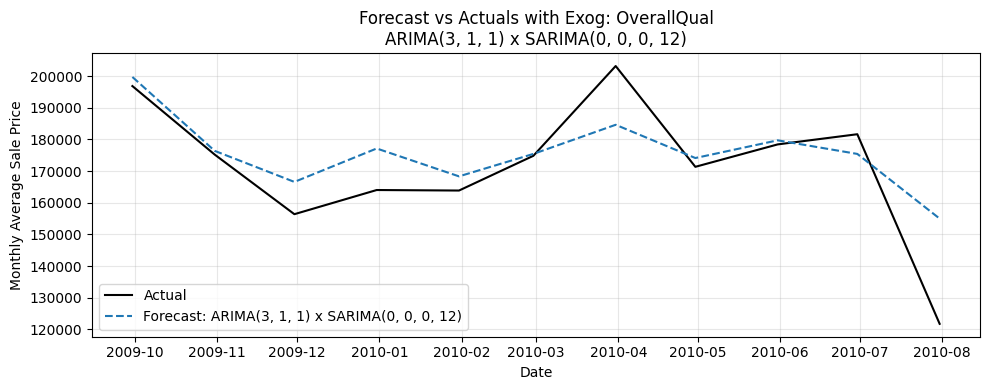

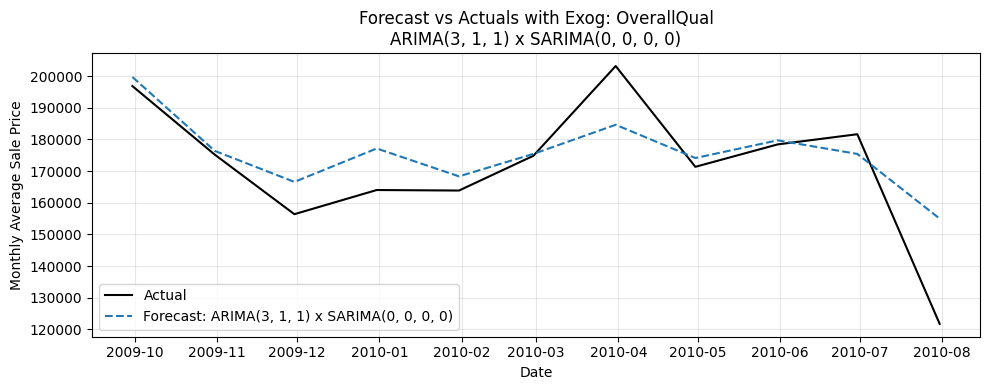

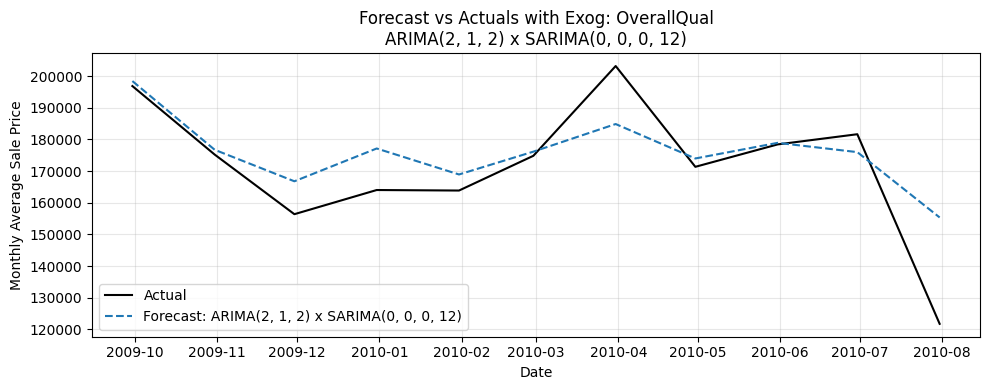

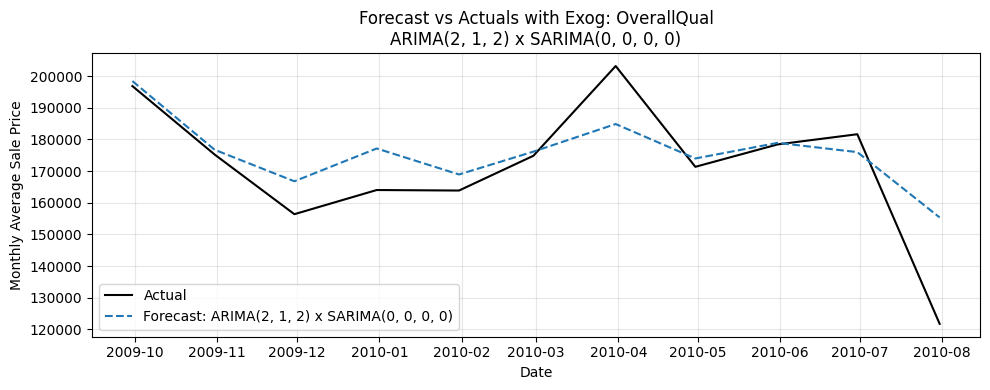

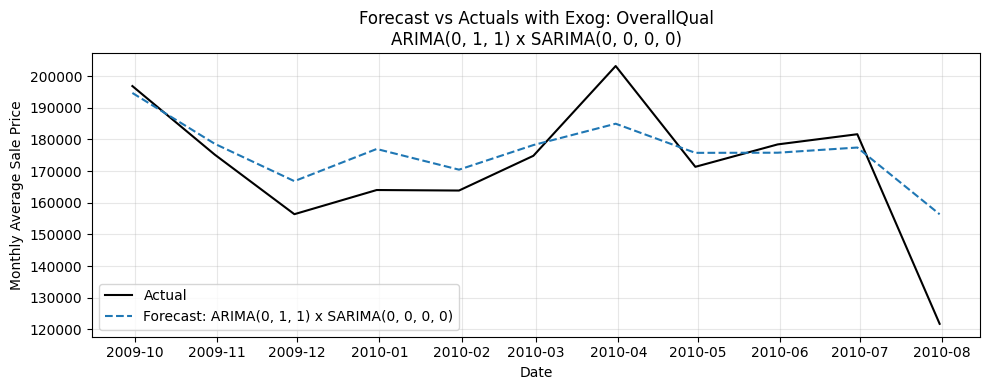

In [33]:
# Log of monthly average fitted with SARIMAX with exogenous variable

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and prepare the data
df = pd.read_csv('../data/raw/train.csv')
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')
df.set_index('Date', inplace=True)

# Aggregate to monthly average
monthly_avg = df.resample('ME').agg({
    'SalePrice': 'mean',
    'OverallQual': 'mean'
}).dropna()

# Fix datetime index frequency
monthly_avg.index = pd.date_range(start=monthly_avg.index[0], periods=len(monthly_avg), freq='ME')

# Log-transform SalePrice
log_monthly_avg = np.log(monthly_avg['SalePrice']).to_frame(name='LogAverageSalePrice')
exog_data = monthly_avg[['OverallQual']]

# # Split dataset
# n = len(log_monthly_avg)
# split = int(n * 0.9)
# split2 = int(n * 0.1)

# train = pd.concat([log_monthly_avg.iloc[:split2], log_monthly_avg.iloc[split:]])
# test = log_monthly_avg.iloc[split2:split]
# exog_train = pd.concat([exog_data.iloc[:split2], exog_data.iloc[split:]])
# exog_test = exog_data.iloc[split2:split]

n = len(log_monthly_avg)
split = int(n * 0.8)  # 80% for training, 20% for testing

train = log_monthly_avg.iloc[:split]
test = log_monthly_avg.iloc[split:]

exog_train = exog_data.iloc[:split]
exog_test = exog_data.iloc[split:]

# SARIMAX model combinations
non_seasonal_orders = [(1,1,1), (2,1,0), (2,1,2), (3,1,1), (1,0,0), (1,0,1), (0,1,1), (0,0,1)]
seasonal_orders = [(0,1,1,12), (0,0,0,12), (0,0,0,0)]


results = {}

for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()
        exog_history = exog_train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(
                    history,
                    exog=exog_history,
                    order=ns_order,
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                forecast_log = model.forecast(steps=1, exog=exog_test.iloc[[t]]).iloc[0]
                actual_log = test['LogAverageSalePrice'].iloc[t]

                # Avoid overflow in exp
                if forecast_log < 20:
                    preds.append(np.exp(forecast_log))
                else:
                    preds.append(np.nan)

                actuals.append(np.exp(actual_log))
                aics.append(model.aic)

                history = pd.concat([history, test.iloc[[t]]])
                exog_history = pd.concat([exog_history, exog_test.iloc[[t]]])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            actuals_arr = np.array(actuals)
            preds_arr = np.array(preds)
            relative_errors = (preds_arr - actuals_arr) / actuals_arr
            var_error = np.nanvar(relative_errors)
            avg_aic = np.nanmean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': relative_errors,
                'Variance of Relative Forecast Error': var_error,
                'AIC': avg_aic
            }

# Summary of results
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Relative Forecast Error Variance': res['Variance of Relative Forecast Error'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Relative Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Relative Forecast Error Variance', 'AIC']])


# Plot top 2 models
for name in summary_df['Model'][:5]:
    res = results[name]
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals with Exog: OverallQual\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\U

                                   Model  Relative Forecast Error Variance  \
0   ARIMA(1, 0, 0) x SARIMA(0, 0, 0, 12)                          0.008446   
1    ARIMA(1, 0, 0) x SARIMA(0, 0, 0, 0)                          0.008446   
2    ARIMA(0, 0, 1) x SARIMA(0, 0, 0, 0)                          0.008491   
3   ARIMA(0, 0, 1) x SARIMA(0, 0, 0, 12)                          0.008491   
4    ARIMA(1, 0, 1) x SARIMA(0, 0, 0, 0)                          0.008537   
5   ARIMA(1, 0, 1) x SARIMA(0, 0, 0, 12)                          0.008537   
6   ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 12)                          0.009176   
7    ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 0)                          0.009176   
8   ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 12)                          0.009283   
9    ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 0)                          0.009283   
10  ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 12)                          0.009372   
11   ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 0)                        

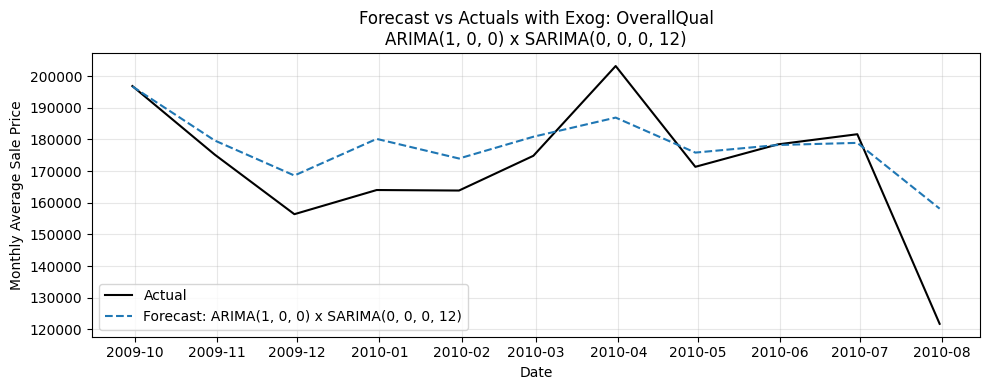

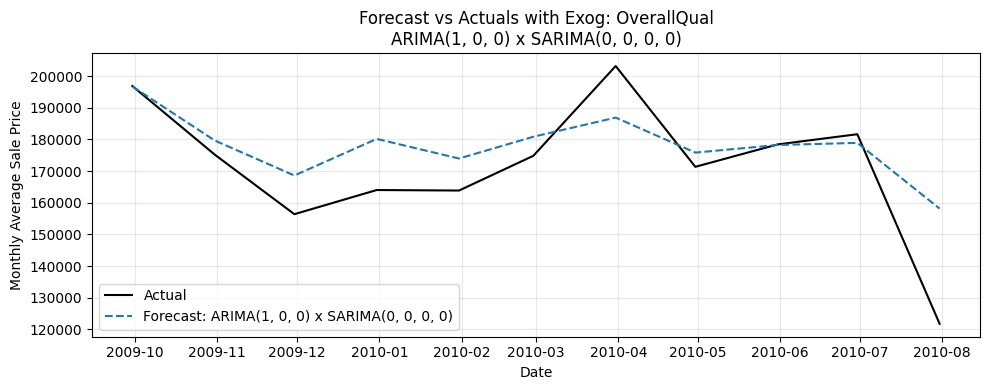

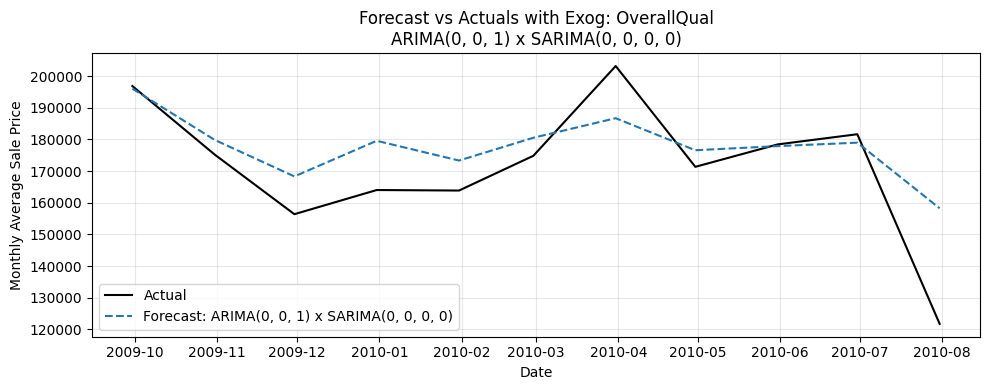

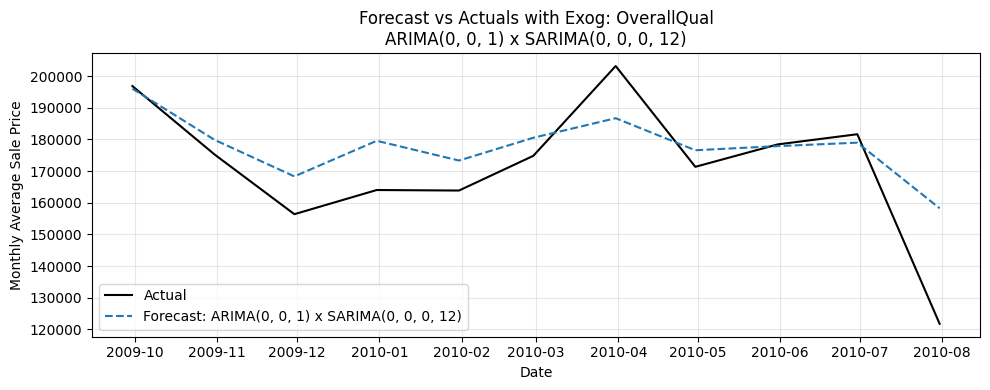

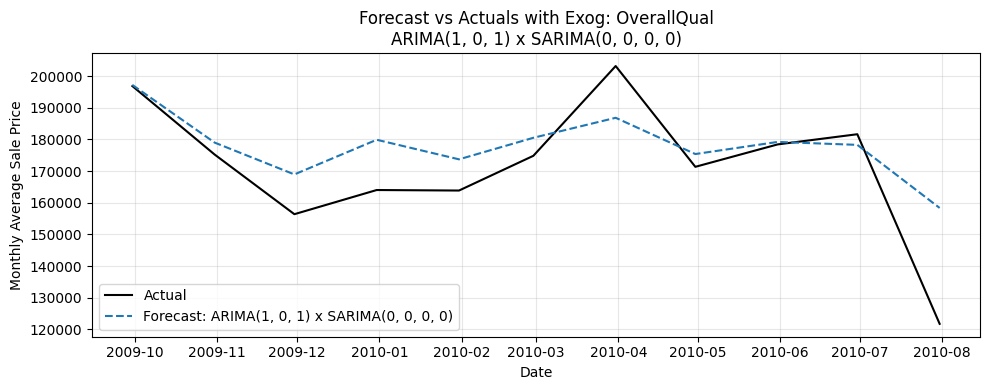

In [58]:
# Monthly average fitted with SARIMAX with exogenous variable

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and prepare the data
df = pd.read_csv('../data/raw/train.csv')
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')
df.set_index('Date', inplace=True)

# Aggregate to monthly average
monthly_avg = df.resample('ME').agg({
    'SalePrice': 'mean',
    'OverallQual': 'mean'
}).dropna()

# Fix datetime index frequency
monthly_avg.index = pd.date_range(start=monthly_avg.index[0], periods=len(monthly_avg), freq='ME')

# Target and exogenous variables
target = monthly_avg[['SalePrice']]
exog_data = monthly_avg[['OverallQual']]

# Train-test split (80% train, 20% test)
n = len(target)
split = int(n * 0.8)

train = target.iloc[:split]
test = target.iloc[split:]

exog_train = exog_data.iloc[:split]
exog_test = exog_data.iloc[split:]

# Model parameter grids
non_seasonal_orders = [(1,1,1), (2,1,0), (2,1,2), (3,1,1), (1,0,0), (1,0,1), (0,1,1), (0,0,1)]
seasonal_orders = [(0,1,1,12), (0,0,0,12), (0,0,0,0)]

results = {}

# Fit models
for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()
        exog_history = exog_train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(
                    history,
                    exog=exog_history,
                    order=ns_order,
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                forecast = model.forecast(steps=1, exog=exog_test.iloc[[t]]).iloc[0]
                actual = test['SalePrice'].iloc[t]

                preds.append(forecast)
                actuals.append(actual)
                aics.append(model.aic)

                history = pd.concat([history, test.iloc[[t]]])
                exog_history = pd.concat([exog_history, exog_test.iloc[[t]]])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            actuals_arr = np.array(actuals)
            preds_arr = np.array(preds)
            relative_errors = (preds_arr - actuals_arr) / actuals_arr
            var_error = np.nanvar(relative_errors)
            avg_aic = np.nanmean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': relative_errors,
                'Relative Forecast Error Variance': var_error,
                'AIC': avg_aic
            }

# Summary of results
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Relative Forecast Error Variance': res['Relative Forecast Error Variance'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Relative Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Relative Forecast Error Variance', 'AIC']])

# Plot top 5 models
for name in summary_df['Model'][:5]:
    res = results[name]
    x = test.index[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals with Exog: OverallQual\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# Forecasting future values

# Define number of months to forecast
forecast_steps = 6

# Generate future datetime index
last_date = monthly_avg.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')

# Use the last known value of OverallQual for future exog
last_known_qual = exog_data.iloc[-1]['OverallQual']
future_exog = pd.DataFrame({
    'OverallQual': [last_known_qual] * forecast_steps
}, index=future_dates)

# Fit the model on the log-transformed data
model = SARIMAX(
    log_monthly_avg, 
    exog=exog_data,
    order=(3, 1, 1),
    seasonal_order=(0, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast in log scale, then exponentiate to get back to original scale
forecast_log = model.forecast(steps=forecast_steps, exog=future_exog)
forecast = np.exp(forecast_log)

# Combine with dates
forecast.index = future_dates
print(forecast)

plt.figure(figsize=(10, 4))
plt.plot(monthly_avg.index, monthly_avg['AverageSalePrice'], label='Historical')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.title("Future Forecast (Next 6 Months)")
plt.xlabel("Date")
plt.ylabel("Average Sale Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-p

                                   Model  Relative Forecast Error Variance  \
0   ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 12)                          0.007630   
1    ARIMA(2, 1, 2) x SARIMA(0, 0, 0, 0)                          0.007630   
2   ARIMA(1, 0, 0) x SARIMA(0, 0, 0, 12)                          0.007997   
3    ARIMA(1, 0, 0) x SARIMA(0, 0, 0, 0)                          0.007997   
4    ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 0)                          0.008065   
5   ARIMA(0, 1, 1) x SARIMA(0, 0, 0, 12)                          0.008065   
6    ARIMA(0, 0, 1) x SARIMA(0, 0, 0, 0)                          0.008091   
7   ARIMA(0, 0, 1) x SARIMA(0, 0, 0, 12)                          0.008091   
8   ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 12)                          0.008324   
9    ARIMA(3, 1, 1) x SARIMA(0, 0, 0, 0)                          0.008324   
10   ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 0)                          0.008516   
11  ARIMA(1, 1, 1) x SARIMA(0, 0, 0, 12)                        

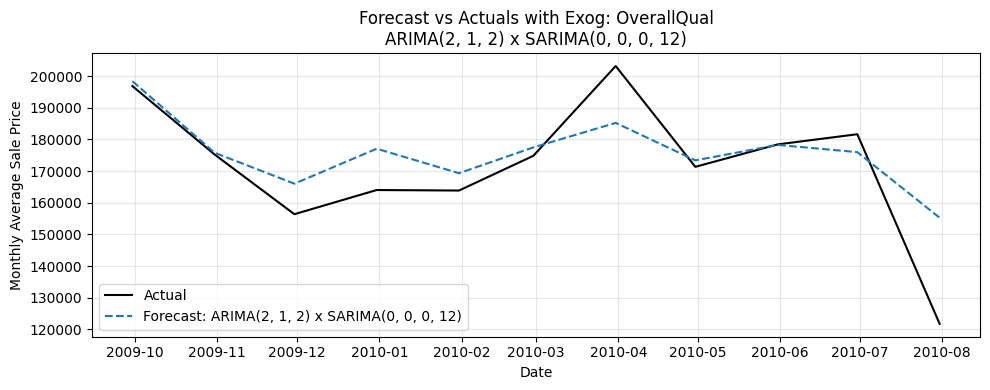

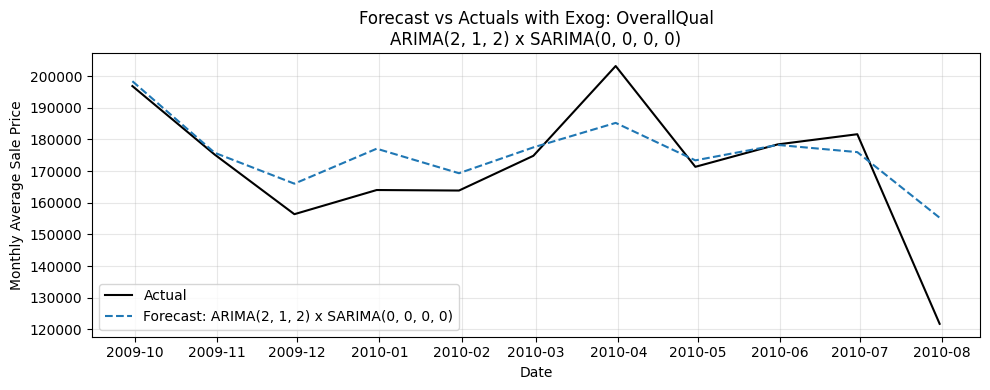

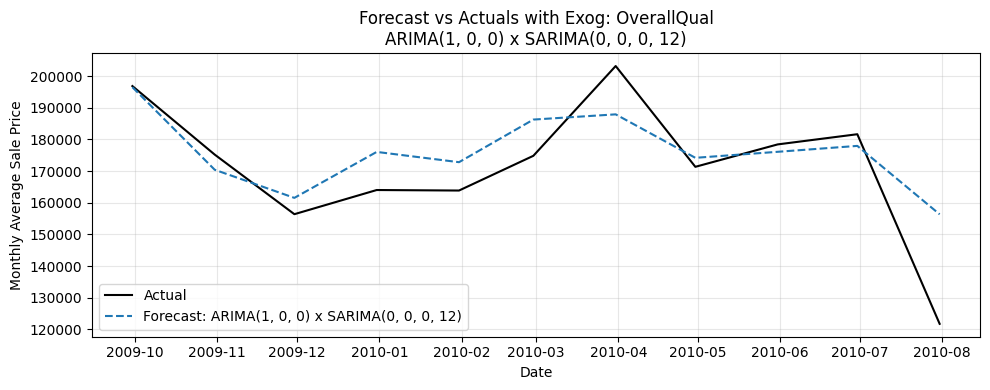

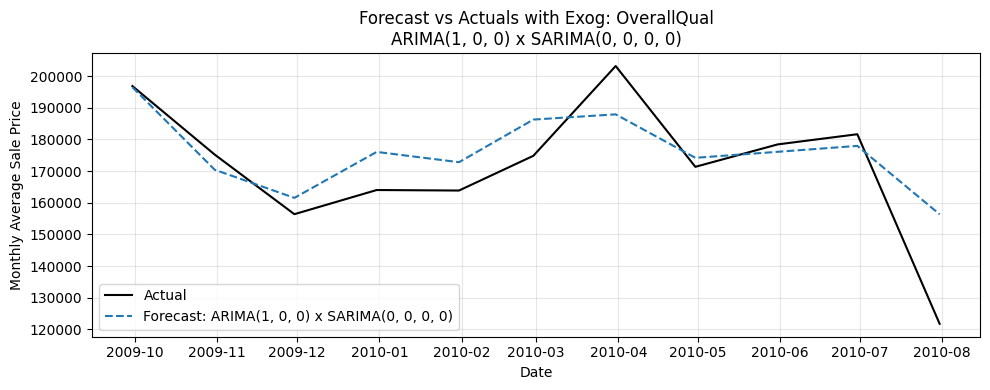

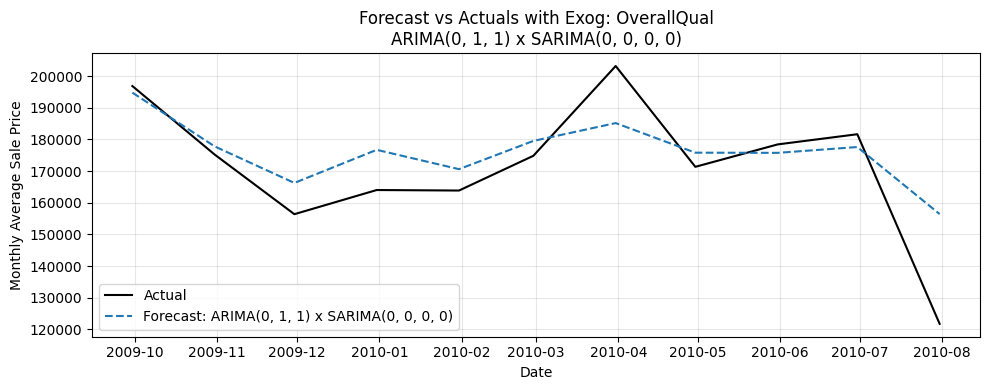

In [ ]:
# Best model with exogenous 2 variables

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and prepare the data
df = pd.read_csv('../data/raw/train.csv')
df['Date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')
df.set_index('Date', inplace=True)

# Aggregate to monthly average
monthly_avg = df.resample('ME').agg({
    'SalePrice': 'mean',
    'YearBuilt': 'mean',
    'OverallQual': 'mean',
    # 'OverallCond': 'mean',
    # 'GrLivArea': 'mean', n'est pas probant voir même fausse 
}).dropna()


# Fix datetime index frequency
monthly_avg.index = pd.date_range(start=monthly_avg.index[0], periods=len(monthly_avg), freq='ME')

# Log-transform SalePrice
log_monthly_avg = np.log(monthly_avg['SalePrice']).to_frame(name='LogAverageSalePrice')
exog_data = monthly_avg[['YearBuilt', 'OverallQual']]  # DON'T PUT SalePrice HERE DUMB CUNT

# # Split dataset
# n = len(log_monthly_avg)
# split = int(n * 0.9)
# split2 = int(n * 0.1)

# train = pd.concat([log_monthly_avg.iloc[:split2], log_monthly_avg.iloc[split:]])
# test = log_monthly_avg.iloc[split2:split]
# exog_train = pd.concat([exog_data.iloc[:split2], exog_data.iloc[split:]])
# exog_test = exog_data.iloc[split2:split]

n = len(log_monthly_avg)
split = int(n * 0.8)  # 80% for training, 20% for testing

train = log_monthly_avg.iloc[:split]
test = log_monthly_avg.iloc[split:]

exog_train = exog_data.iloc[:split]
exog_test = exog_data.iloc[split:]

# SARIMAX model combinations
non_seasonal_orders = [(1,1,1), (2,1,0), (2,1,2), (3,1,1), (1,0,0), (1,0,1), (0,1,1), (0,0,1)]
seasonal_orders = [(0,1,1,12), (0,0,0,12), (0,0,0,0)]


results = {}

for ns_order in non_seasonal_orders:
    for s_order in seasonal_orders:
        label = f'ARIMA{ns_order} x SARIMA{s_order}'
        preds = []
        actuals = []
        aics = []
        history = train.copy()
        exog_history = exog_train.copy()

        for t in range(len(test)):
            try:
                model = SARIMAX(
                    history,
                    exog=exog_history,
                    order=ns_order,
                    seasonal_order=s_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                forecast_log = model.forecast(steps=1, exog=exog_test.iloc[[t]]).iloc[0]
                actual_log = test['LogAverageSalePrice'].iloc[t]

                # Avoid overflow in exp
                if forecast_log < 20:
                    preds.append(np.exp(forecast_log))
                else:
                    preds.append(np.nan)

                actuals.append(np.exp(actual_log))
                aics.append(model.aic)

                history = pd.concat([history, test.iloc[[t]]])
                exog_history = pd.concat([exog_history, exog_test.iloc[[t]]])
            except Exception as e:
                print(f"Model {label} failed: {e}")
                break

        if len(actuals) > 0:
            actuals_arr = np.array(actuals)
            preds_arr = np.array(preds)
            relative_errors = (preds_arr - actuals_arr) / actuals_arr
            var_error = np.nanvar(relative_errors)
            avg_aic = np.nanmean(aics) if aics else np.nan
            results[label] = {
                'Forecasts': preds,
                'Actuals': actuals,
                'Errors': relative_errors,
                'Variance of Relative Forecast Error': var_error,
                'AIC': avg_aic
            }

# Summary of results
summary_df = pd.DataFrame([
    {
        'Model': name,
        'Relative Forecast Error Variance': res['Variance of Relative Forecast Error'],
        'AIC': res['AIC']
    }
    for name, res in results.items()
]).sort_values('Relative Forecast Error Variance').reset_index(drop=True)

print(summary_df[['Model', 'Relative Forecast Error Variance', 'AIC']])


# Plot top 5 models
for name in summary_df['Model'][:5]:
    res = results[name]
    x = test.index.values[:len(res['Actuals'])]
    actuals = np.array(res['Actuals'])
    forecasts = np.array(res['Forecasts'])
    plt.figure(figsize=(10, 4))
    plt.plot(x, actuals, label='Actual', color='black')
    plt.plot(x, forecasts, label=f'Forecast: {name}', linestyle='--')
    plt.title(f'Forecast vs Actuals with Exog: OverallQual\n{name}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Average Sale Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [66]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -----------------------------------
# Step 1: Load and prepare training data
# -----------------------------------
df_train = pd.read_csv('../data/raw/train.csv')
df_train['Date'] = pd.to_datetime(df_train['YrSold'].astype(str) + '-' + df_train['MoSold'].astype(str) + '-01')
df_train.set_index('Date', inplace=True)

monthly_train = df_train.resample('ME').agg({
    'SalePrice': 'mean',
    'YearBuilt': 'mean',
    'OverallQual': 'mean'
}).dropna()
monthly_train.index = pd.date_range(start=monthly_train.index[0], periods=len(monthly_train), freq='ME')

log_train_target = np.log(monthly_train['SalePrice']).to_frame(name='LogAverageSalePrice')
exog_train = monthly_train[['YearBuilt', 'OverallQual']]

# -----------------------------------
# Step 2: Fit SARIMAX model (your best config)
# -----------------------------------
best_ns_order = (2, 1, 2)
best_s_order = (0, 0, 0, 12)

best_model = SARIMAX(
    log_train_target,
    exog=exog_train,
    order=best_ns_order,
    seasonal_order=best_s_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# -----------------------------------
# Step 3: Load and prepare test data
# -----------------------------------
df_test = pd.read_csv("../data/raw/test.csv")
df_test = df_test.dropna(subset=['YearBuilt', 'OverallQual', 'MoSold', 'YrSold'])  # ensure required exog data

# Create 'Date' column for forecasting
df_test['Date'] = pd.to_datetime(df_test['YrSold'].astype(str) + '-' + df_test['MoSold'].astype(str) + '-01')

# Create monthly exogenous inputs for SARIMAX forecast
monthly_exog = df_test.groupby('Date')[['YearBuilt', 'OverallQual']].mean().sort_index()
monthly_exog = monthly_exog.reset_index()  # 'Date' becomes a column

# -----------------------------------
# Step 4: Forecast and assign back
# -----------------------------------
log_forecast = best_model.forecast(steps=len(monthly_exog), exog=monthly_exog[['YearBuilt', 'OverallQual']])
forecast = np.exp(log_forecast)
monthly_exog['PredictedSalePrice'] = forecast.values

# Merge forecasted prices back to test data
df_test = df_test.merge(monthly_exog[['Date', 'PredictedSalePrice']], on='Date', how='left')

# Assign predicted price
df_test['SalePrice'] = df_test['PredictedSalePrice']

# Fallback for any missing predictions
fallback_price = monthly_train['SalePrice'].median()
df_test['SalePrice'] = df_test['SalePrice'].fillna(method='ffill').fillna(fallback_price)

# -----------------------------------
# Step 5: Export submission file
# -----------------------------------
submission = df_test[['Id', 'SalePrice']].copy()
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv created and saved.")
print(submission.head())


✅ submission.csv created and saved.
     Id      SalePrice
0  1461  160623.554588
1  1462  160623.554588
2  1463  157724.414842
3  1464  160623.554588
4  1465  190978.635584


c:\Users\Gouvernon Tim\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Gouvernon Tim\AppData\Local\Temp\ipykernel_8960\3620714522.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test['SalePrice'] = df_test['SalePrice'].fillna(method='ffill').fillna(fallback_price)


In [67]:
# number of rows in submission.csv
submission = pd.read_csv("submission.csv")
print("Number of rows in submission.csv:", len(submission))

Number of rows in submission.csv: 1459
